# 04 Detailed Balance: Connecting Microscopic and Macroscopic World

In [1]:
# packages import
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import time
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

## A. Motivation
In the previous notebook on[ Discrete-Time Markov Chains](https://github.com/ridhoma/monte-cafe/blob/main/notebooks/03%20Discrete-Time%20Markov%20Chain.ipynb), we demonstrated that a Markov Chain with transition matrix $P$ (provided it is irreducible and aperiodic) will converge to a stationary distribution $\pi$ after being run for a sufficiently long time. This stationary distribution satisfies the relation: $\pi = P\pi$, which is a system of linear equations. This means that $\pi$ can, in principle, be calculated directly from $P$ without having to actually run the Markov-Chain.

However, in many statistical analysis applications, the situation is reversed; $\pi$ is given (i.e. our choice) as the target distribution we want to sampling from. The challenge is then to construct a Markov-Chain transition matrix $P$ such that when we run the chain over a long time the stationary distribution converge to the desired $\pi$. The task of obtaining $P$ from $\pi$ is nontrivial (i.e. difficult), unless we impose another condition beyond irreducibility and aperiodicity, known as reversibility or **detailed balance**.

The detailed balance condition allows us to construct $P$ analytically, ensuring that it leads to the desired stationary distribution $\pi$. One of the most widely used methods for constructing $P$ by explicitly enforcing the detailed balance condition is the **Metropolis-Hastings** algorithm. In the following, we will derive the algorithm mathematically and implement it from scratch.



## B. Detailed Balance

The detailed balance condition says; 
> For a distribution function $\pi$, there is a Markov-Chain with transition probability $P$ that satisfied relation
$$
\pi(x)P(x, y) = \pi(y)P(y,x)
$$  
> and it is guaranteed that $\pi$ is stationary distribution

### Markov-Chain as Particles Migration System
A useful way to visualize this equation is to imagine a 2-states Markov-Chain system of partciles, where $\pi = [\pi_A, \pi_B]$ are number of particles in state-A and state-B respectively. The particles can move from one state to another according to transition matrix $P$ that satisfies the detailed balance relation. In essence;
$$
\pi_A P(A \rightarrow B) = \pi_B P(B \rightarrow A)
$$

When the Markov-Chain is run, every single particle in one state will independently and randomly move to the other state based on trasition probability matrix $P$. At each time step we will keep track on the number of particles in each state. This simulation's implementation can be checked in [models/markov_chain.py](https://github.com/ridhoma/monte-cafe/blob/main/models/markov_chain.py) under function `random_particle_migrations()`.

cell below is the implementaion of such system

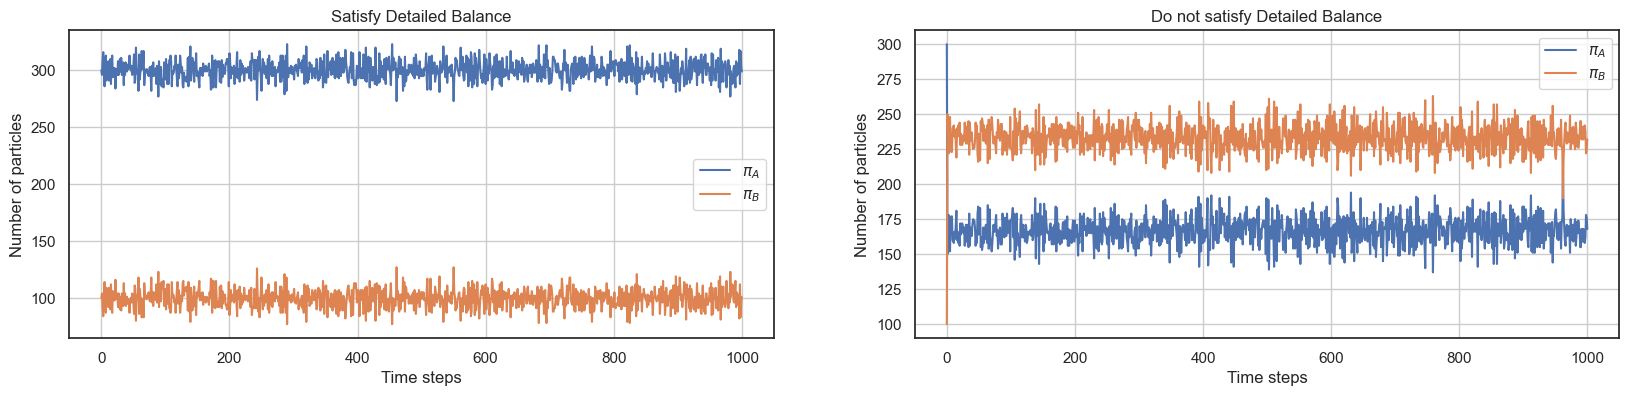

In [2]:
# Markov-Chain as system of particles
from models import markov_chain as mc

# let's define a distribution pi where there are 100 particles in state-A and 30 particles in state-B
pi = [300, 100]

# Let's set transition matrix P based on the detailed balance condition
P_detailed_balance = \
    np.array([[0.7, 0.3],  # A -> A, B
              [0.9, 0.1]])  # B -> A, B
# Let's define another arbirtray transition matrix that does not satisfy detailed balance condition as comparison
P_arbitrary = \
    np.array([[0.3, 0.7],  # A -> A, B
              [0.5, 0.5]])  # B -> A, B

# run the Markov-Chain to proof whether pi is stationary.
# Note that pi is defined before P, unlike in the previous exercise where we only define P and calculate pi later
max_steps = 1000
pi_evolutions, particles_states_evolution = mc.random_particle_migrations(P_detailed_balance, pi, max_steps=max_steps)
pi_evolutions_arbitrary, particles_states_evolution_arbitrary = mc.random_particle_migrations(P_arbitrary, pi, max_steps=max_steps)

# plot the evolution of the states disctribution
def plot_pi_evolution(pi_evol, ax, title=None):
    ax.plot(pi_evol[:,0], label='$\pi_A$')
    ax.plot(pi_evol[:,1], label='$\pi_B$')
    ax.legend()
    ax.grid()
    ax.set_ylabel('Number of particles')
    ax.set_xlabel('Time steps')
    ax.set_title(title)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
plot_pi_evolution(pi_evolutions, ax=ax1, title="Satisfy Detailed Balance")
plot_pi_evolution(pi_evolutions_arbitrary, ax=ax2, title="Do not satisfy Detailed Balance")

As shown above, Markov-Chain that satisfies detailed balance has $\pi = [300,100]$ constant from the start until the end of the simulation, in essence $\pi$ defined before the simulation is ran is already the stationary distribution.
On the other hand, in Markov-Chain that does not satisfy detaield balance, although the distribution still converges to some stationary values but it the value has changed from the initial value,$\pi \neq [300,100]$.

In other words, ensuring transition matrix $P$ and a pre-defined distribution $\pi$ to satisfy the detailed balance equation guarantees that $\pi$ will be the stationary distribution.

In order to see exactly what's going on, let's animate the particle migration simulation

In [3]:
# Visualizing the simulation of particles migrations

from utils import math_utils

transition_frames = 15
particles_paths = []
for p in range(particles_states_evolution.shape[1]): # iterate over all particles
    states = particles_states_evolution[:,p]
    particle_path = []
    for t in range(1, 20): # animate the particle migration only until timestep=20
        prev_s, curr_s = states[t-1], states[t]
        radius = {0: pi[0]/max(pi), 1:pi[1]/max(pi)}
        prev_xy = math_utils.generate_random_points_around_center([[2*prev_s, 0]], radius=radius[prev_s]*0.3)[0]
        curr_xy = math_utils.generate_random_points_around_center([[2*curr_s, 0]], radius=radius[curr_s]*0.3)[0]
        if prev_s == curr_s:
            xy_path = math_utils.calculate_linear_path(prev_xy, curr_xy, transition_frames)
        else:
            upward = True if prev_s < curr_s else False
            xy_path = math_utils.calculate_parabola_path(prev_xy, curr_xy, transition_frames, upward)
        particle_path.append(xy_path)
    particle_path = np.concatenate(particle_path)
    particles_paths.append(particle_path)
particles_paths = np.stack(particles_paths, axis=1)


from matplotlib.animation import FuncAnimation
from utils import viz_utils
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(12,2))
fig.dpi=120
def update_particles_positions(frame):
    ax.clear()
    pos = np.squeeze(particles_paths[frame,:,:])
    viz_utils.plot_particles(pos, ax=ax, marker_size=1)
    ax.set_xlim([-0.5, 2.5])
    ax.set_ylim([-1, 1])
    cur_pi = pi_evolutions[frame//transition_frames]
    ax.annotate(f'state-A ($\pi = {cur_pi[0]}$)', xy=(0,0.5), ha='center', fontsize=10, c='tab:blue')
    ax.annotate(f'state-B ($\pi = {cur_pi[1]}$)', xy=(2,0.5), ha='center', fontsize=10, c='tab:orange')

n_frames, fps = particle_path.shape[0], 30
anim = FuncAnimation(
    fig, 
    init_func=lambda: update_particles_positions(0),
    func=update_particles_positions, 
    frames=n_frames, interval=1000/fps,
    repeat=False, blit=False)
# anim.save(filename="particle_move.mp4", writer="ffmpeg", fps=30)
plt.close()
HTML(anim.to_jshtml())

# Reflection: Interpretation of Detailed-Balance

In the particle migration simulation above, it can be seen that every time steps, tehre will be particles migrate from one state to the other. However, the number of particles in each state at every time steps is always constant, which is also shown in the stationary distribution plot over time previously.

The time evolution plot of stationary distribution $\pi(t)$ can be interpreted as the macroscopic behavior of the system. While the particle migration simulation animation can be interpreted as microscopy dynamics of the system. It is fascinating that although at microscopic level the system is dynamics (changing/moving), at macroscopic level the behavior is unchanged. The system is said to be in equilibrium in this situation, and this is a hallmark of the detailed balance. The detailed-balance condition demonstrates that when a system is in equilibrium, the observed (macroscopic) behavior can be analyze statistically without having to analyze every single microscopic constituents.

This can be brought to many subject from phsyics to social behavior. For example, in thermodynamics in order to predict how a system behave macroscopically (heat transfer, chemical reaction, etc.) we don't have to calculate the behavior of each partcile/molecule, but rather we can describe the system statistically (i.e. using a probability distribution function). In business and social-science, in order to predict customer behavior and their impact to business (macroscopically) we don't have to analyze the behavior of every single customer (microscopically) but rather we can model their behavior using statistics using probability distribution function.

# End of notebook